## Выполнили: Габбасов Раиль (6231) и Борисов Дмитрий (6233)

### Задание: https://github.com/itsecd/ml-for-sec-lab3/blob/main/Lab%203%20-%20Task.pdf
### Статья: https://arxiv.org/pdf/2012.00468.pdf
### Вариант: B1

# Environment Setup

In [1]:
!sudo apt-get install libmagickwand-dev
!pip install --no-cache-dir \
    opencv-python-headless==4.6.*\
    rawpy==0.17.* \
    pandas \
    Pillow==7.1.2 \
    scikit-image==0.16.2 \
    scipy==1.5.0 \
    tqdm \
    Wand

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagickwand-dev is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
REPO_URL = "https://github.com/andreacos/BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation"

In [3]:
!git clone $REPO_URL

fatal: destination path 'BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation' already exists and is not an empty directory.


In [4]:
import sys

REPO_PATH = REPO_URL.split('/')[-1]
sys.path.append(REPO_PATH)

REPO_PATH

'BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation'

# Imports

In [5]:
import io
import itertools
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from skimage.util import view_as_windows

# Dataset preparation

In [6]:
DATA_DIR = 'data'
MAX_IMAGE_SIZE = (192, 192)

In [7]:
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

In [8]:
df_metainfo = pd.read_csv('drive/MyDrive/RAISE_1k.csv')
df_metainfo.head()

,File,NEF,TIFF,Date Created,Date Modified,File Size,Image Size,Date Shot,Time Zone and Date,Image Quality,...,Sharpening.1,Latitude,Longitude,Altitude,Altitude Reference,Heading,UTC,Map Datum,Scene Mode,Keywords
0,r000da54ft,http://193.205.194.113/RAISE/NEF/r000da54ft.NEF,http://193.205.194.113/RAISE/TIFF/r000da54ft.TIF,9/20/2014 23:51,3/19/2012 9:14,9.79 MB,L (4288 x 2848),14:14.0,"UTC+1, DST:ON",Compressed RAW (12-bit),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nature; outdoor
1,r001d260dt,http://193.205.194.113/RAISE/NEF/r001d260dt.NEF,http://193.205.194.113/RAISE/TIFF/r001d260dt.TIF,9/21/2014 9:58,5/11/2013 6:45,20.0 MB,L (4928 x 3264),45:58.6,"UTC+1, DST:ON",Lossless Compressed RAW (14-bit),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aperture Priority,buildings; outdoor
2,r002fc3e2t,http://193.205.194.113/RAISE/NEF/r002fc3e2t.NEF,http://193.205.194.113/RAISE/TIFF/r002fc3e2t.TIF,9/21/2014 3:29,5/4/2014 8:42,21.5 MB,L (4928 x 3264),42:11.6,"UTC+1, DST:ON",Lossless Compressed RAW (14-bit),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outdoor; people
3,r00444b95t,http://193.205.194.113/RAISE/NEF/r00444b95t.NEF,http://193.205.194.113/RAISE/TIFF/r00444b95t.TIF,9/21/2014 12:20,9/2/2013 11:02,19.8 MB,L (4928 x 3264),02:23.5,"UTC+1, DST:ON",Lossless Compressed RAW (14-bit),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manual,buildings; outdoor
4,r005f3e70t,http://193.205.194.113/RAISE/NEF/r005f3e70t.NEF,http://193.205.194.113/RAISE/TIFF/r005f3e70t.TIF,9/20/2014 23:19,2/18/2012 12:08,10.6 MB,L (4288 x 2848),08:05.0,"UTC+1, DST:OFF",Compressed RAW (12-bit),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,buildings; outdoor


In [9]:
for i, link in enumerate(df_metainfo['TIFF'].iloc[:3].values):
  ! curl "$link" --output "$DATA_DIR"/"$i".tif

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.1M  100 14.1M    0     0  5621k      0  0:00:02  0:00:02 --:--:-- 5619k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.6M  100 19.6M    0     0  6919k      0  0:00:02  0:00:02 --:--:-- 6917k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.2M  100 31.2M    0     0  8633k      0  0:00:03  0:00:03 --:--:-- 8630k


In [10]:
def compress_image(image, qf):
    jpeg_encoded = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), qf])[1]
    jpeg_encoded_image = Image.open(io.BytesIO(jpeg_encoded))
    return np.array(jpeg_encoded_image)

In [11]:
def get_patch(source: np.ndarray, patch_shape, loc):
    return source[loc[0]:loc[0]+patch_shape[0], loc[1]:loc[1]+patch_shape[1]]

def insert_patch(dest: np.ndarray, patch: np.ndarray, loc):
    dest_ = dest.copy()
    dest_[loc[0]:loc[0]+patch.shape[0], loc[1]:loc[1]+patch.shape[1]] = patch
    return dest_

def generate_random_patch_location(dest_shape, patch_shape):
    return np.random.randint(0, dest_shape[0] - patch_shape[0] + 1), np.random.randint(0, dest_shape[1] - patch_shape[1] + 1)

def insert_image_patch(dest: np.ndarray, source: np.ndarray, patch_shape, dest_loc=None, source_loc=None):
    if dest_loc is None:
        dest_loc = generate_random_patch_location(dest.shape, patch_shape)
    if source_loc is None:
        source_loc = generate_random_patch_location(source.shape, patch_shape)
    
    patch = get_patch(source, patch_shape, source_loc)
    result_image = insert_patch(dest, patch, dest_loc)
    mask = insert_patch(np.zeros(dest.shape[:2]), np.ones(patch_shape[:2]), dest_loc)
    return result_image, mask

In [12]:
def prepare_dataset(paths, qf11, qf12, qf2):

    for im1_path, im2_path in itertools.permutations(paths, 2):

        im1 = cv2.resize(cv2.imread(str(im1_path)), MAX_IMAGE_SIZE, interpolation=cv2.INTER_AREA)
        im1_jpg = compress_image(im1, qf11)

        im2 = cv2.resize(cv2.imread(str(im2_path)), MAX_IMAGE_SIZE, interpolation=cv2.INTER_AREA)
        im2_jpg = compress_image(im2, qf12)

        patch = im2_jpg[:64, :64]

        result, mask = insert_image_patch(dest=im1_jpg, source=im2_jpg, patch_shape=(64, 64))

        yield compress_image(result, qf2), mask

In [13]:
dataset = list(prepare_dataset(Path(DATA_DIR).glob('*.tif'), qf11=50, qf12=70, qf2=90))

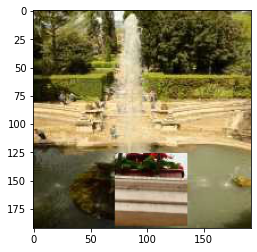

In [14]:
plt.imshow(dataset[0][0][..., ::-1])

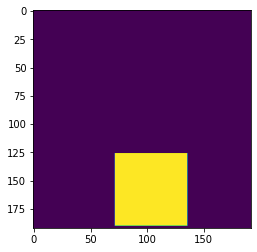

In [15]:
plt.imshow(dataset[0][1])

# Model setup

In [16]:
from networks import custom_two_terms_loss_wrapper, custom_softmax_activation, custom_mse_wrapper
from utils import max_min_coefficient, label2coefficient#, string2Q


def preprocess_input(im, scale=255.):
    """Does channel transformation and scaling"""
    im = np.expand_dims(cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)[:, :, 0], -1)
    return im.astype(np.float32) / scale


def window_decision(img_data, model, max_coeffs, win_size=(64, 64), stride=1):
    """Divide input image into blocks then classify each block with a trained CNN model. Block scores are aggregated
       by means of average soft decision **on probability of being contrast enhanced**.
    Args:
       img_data: image matrix.
       model: trained CNN model (Keras)
       win_size: (height, width) of the image blocks. Default: (64, 64)
        stride: window stride
    Returns:
       Score
    """

    # Divide image into overlapping blocks
    image_view = view_as_windows(img_data, [win_size[0], win_size[1], 1], stride)

    h, w, c, _, _, _ = image_view.shape

    # Reshape the image view so that it is a stack of size N_blocks. Each element is a color patch BxBx3
    slices = image_view.reshape(h * w * c, win_size[0], win_size[1], 1)

    # Test the stack
    prediction = model.predict(slices, verbose=0)

    # Decode labels
    decoded_labels = np.zeros((prediction.shape[0], 15))
    for i, p in enumerate(prediction):
        decoded_labels[i, :] = label2coefficient(p.flatten(), max_coefficients=max_coeffs)

    # Reshape decoded labels to the final map
    decoded_map = np.reshape(decoded_labels, (h, w, 15))
    decoded_map = cv2.resize(decoded_map, (img_data.shape[0], img_data.shape[1]))

    return decoded_map, decoded_labels


# Max value for coefficients
max_coeffs, _ = max_min_coefficient(quality_range=(50, 100),
                                    n_coeffs=15,
                                    zig_zag_order=True)

# Load model
model = tf.keras.models.load_model(f'{REPO_PATH}/models/model_QF1_60-98_QF2_90-2-term-loss.h5',
                                   custom_objects=({'custom_softmax': custom_softmax_activation(max_coeffs),
                                                    'custom_two_terms_loss_wrapper': custom_two_terms_loss_wrapper(max_coeffs, 0.8),
                                                    'custom_mse': custom_mse_wrapper(max_coeffs)}))

def get_coefficient_maps(unscaled_colored_jpeg_image):
    return window_decision(preprocess_input(unscaled_colored_jpeg_image), model, max_coeffs, (64, 64, 1), stride=1)[0]

# Image from article

In [17]:
image_from_article = cv2.imread(f'{REPO_PATH}/resources/T_04_758595.jpg')[:192, -192:]
maps = get_coefficient_maps(image_from_article)

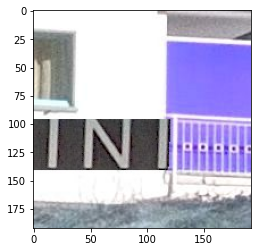

In [18]:
plt.imshow(image_from_article)

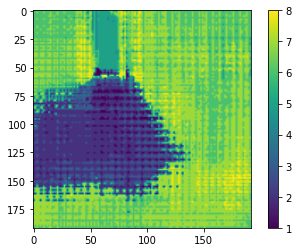

In [19]:
plt.imshow(maps[..., 1])
plt.colorbar()

In [20]:
samples = maps.reshape(-1, maps.shape[-1])

In [21]:
K = 2

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts = 10
ret, label, center = cv2.kmeans(np.float32(samples[:, [1]]), K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

In [22]:
ret

14262.509467551798

In [23]:
label

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [24]:
center

array([[6.4917097],
       [2.21619  ]], dtype=float32)

In [25]:
segm_ans = label.reshape(maps.shape[:2])

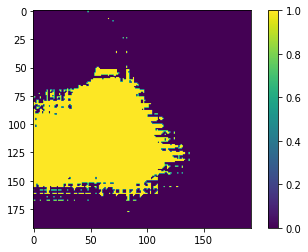

In [26]:
plt.imshow(segm_ans)
plt.colorbar()

In [27]:
np.unique(segm_ans)

array([0, 1], dtype=int32)

# Run on the dataset

In [28]:
def get_mask_kmeans(maps, feature_set=None):
    samples = maps.reshape(-1, maps.shape[-1])

    if feature_set is not None:
        samples = samples[:, feature_set]

    K = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts = 10
    ret, label, center = cv2.kmeans(np.float32(samples), K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

    return label.reshape(maps.shape[:2])

In [29]:
def accuracy(y_true, y_pred):
    return np.sum(y_pred == y_true) / np.prod(y_true.shape)

def adjust_binary_kmeans_mask(pred_mask, gt_mask):
    if accuracy(gt_mask, pred_mask) < 0.5:
        return (~(pred_mask.astype(bool))).astype(pred_mask.dtype)
    return pred_mask

In [30]:
def find_all(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

def decode_setup(setup_str):
    return find_all(setup_str, '1')

decode_setup('010001000001001')

[1, 5, 11, 14]

In [31]:
desired_features_setups = [
    '1______________',
    '_1_____________',
    '1_1_1_1_1_1_1_1',
    '_1_1_1_1_1_1_1_',
    '111111111111111',
    # '010001000001000'
]

In [32]:
from sklearn.metrics import jaccard_score

df_masks = pd.DataFrame(columns=desired_features_setups)
df_acc = pd.DataFrame(columns=desired_features_setups)
df_jac = pd.DataFrame(columns=desired_features_setups)

In [33]:
for i, (image, gt_mask) in enumerate(dataset):
    print(f'{i+1} / {len(dataset)}')
    maps = get_coefficient_maps(image)
    predicted_masks = [adjust_binary_kmeans_mask(
        get_mask_kmeans(maps, feature_set=decode_setup(features_setup_str)), 
        gt_mask) for features_setup_str in desired_features_setups]
    df_masks.loc[i] = predicted_masks
    df_acc.loc[i] = [accuracy(gt_mask, mask) for mask in predicted_masks]
    df_jac.loc[i] = [jaccard_score(gt_mask, mask, average='micro') for mask in predicted_masks]


1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6


In [34]:
# df_masks

In [35]:
df_acc

,1______________,_1_____________,1_1_1_1_1_1_1_1,_1_1_1_1_1_1_1_,111111111111111
0,0.902805,0.926215,0.905680,0.914741,0.908312
1,0.919244,0.939860,0.922173,0.927138,0.923910
2,0.897976,0.917616,0.900852,0.903564,0.901747
3,0.915229,0.911350,0.915012,0.913276,0.913954
4,0.896973,0.894721,0.912652,0.911133,0.912109
5,0.921631,0.914958,0.924344,0.924859,0.924235


In [36]:
df_jac

,1______________,_1_____________,1_1_1_1_1_1_1_1,_1_1_1_1_1_1_1_,111111111111111
0,0.138909,0.364189,0.166786,0.251845,0.191774
1,0.281265,0.530496,0.308008,0.353394,0.324096
2,0.262404,0.531038,0.317205,0.374670,0.333579
3,0.393322,0.515637,0.422062,0.460057,0.442922
4,0.108241,0.384066,0.321963,0.374690,0.363708
5,0.335862,0.478109,0.364692,0.382936,0.369241


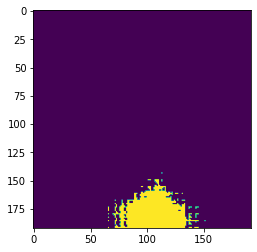

In [37]:
plt.imshow(df_masks.iloc[0]['_1_____________'])

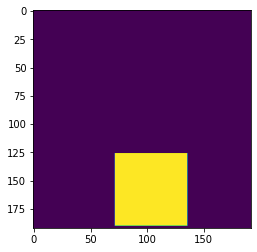

In [38]:
plt.imshow(dataset[0][1])

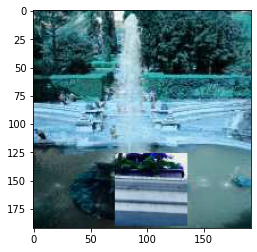

In [39]:
plt.imshow(dataset[0][0])

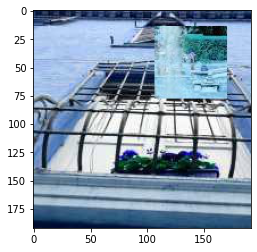

In [40]:
plt.imshow(dataset[2][0])